# Coding With Me: Tensorflow
## Step 0: Explain the notations
* __graph__: A set of vertices and edges. Vertices are linked by the edges.
* __tensor__: Multidimensional array. It can represent data, e.g. a matrix of count numbers, a set of images, string.

## Step 1: Computing with graphs in Tensorflow's _session_
In this step, we will introduce some basic operations and Tensorflow's _session_.

<img src="./hello.PNG" alt="Hello TensorFlow!" width="50%">
Computations among tensors can be regarded as graphs with the vertices as operations and the edges representing tensors.

Firstly, we will introduce some basic tensorflow operations:
* __constant (value, dtype=None, shape=None, name='Const')__: Creates a constant tensor. _name_ is a name for the operator, which is optional.
* __add (x, y, name=None)__: Returns x + y element-wise.

Then, we will introduce Tensorflow's _session_:
* __class Session__: A class for running TensorFlow operations. A Session object encapsulates the environment in which Operation objects are executed, and Tensor objects are evaluated.
* __Session.run (fetches, feed_dict=None, options=None, run_metadata=None)__: Runs the operations and evaluates the tensors in fetches. This method runs one "step" of TensorFlow computation, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches argument may be a single graph element, a list of graph elements, or a dictionary whose values are the above. The type of fetches determines the return value of this method. A graph element can be one of the following types: If an element of fetches is an Operation, the corresponding fetched value will be None. If an element of fetches is a Tensor, the corresponding fetched value will be a numpy ndarray containing the value of that tensor. If an element of fetches is a SparseTensor, the corresponding fetched value will be a SparseTensorValue containing the value of that sparse tensor. If an element of fetches is produced by a get_tensor_handle op, the corresponding fetched value will be a numpy ndarray containing the handle of that tensor.


We can find more detailed descriptions at Tensorflow's API document: https://www.tensorflow.org/versions/r0.9/api_docs/index.html

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import input_data

In [2]:
import tensorflow as tf
words = tf.constant('Hello, TensorFlow')
feel = tf.constant('!')
hello = tf.add(words, feel)
sess = tf.Session()
writer = tf.train.SummaryWriter("/root/compute/log", sess.graph) # this step is optional, writing logs of the graph to /root/compute/log
print(sess.run(hello))

Hello, TensorFlow!


## Step 2: Variables and optimization, a simple linear regression

In this step we will get familiar with more operations and concepts:
* __placeholder (dtype, shape=None, name=None)__: Inserts a placeholder for a tensor that will be always fed. _Important: This tensor will produce an error if evaluated. Its value must be fed using the feed_dict optional argument to Session.run(), Tensor.eval(), or Operation.run()._
* __class Variable__: A variable maintains state in the graph across calls to run(). You add a variable to the graph by constructing an instance of the class Variable.
* **Variable.\__init__ (initial_value=None, trainable=True, collections=None, validate_shape=True, caching_device=None, name=None, variable_def=None, dtype=None)**: Creates a new variable with value initial_value.

Optimization, e.g. Gradient Descent. Gradient descent is a first-order optimization algorithm. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or of the approximate gradient) of the function at the current point. If instead one takes steps proportional to the positive of the gradient, one approaches a local maximum of that function; the procedure is then known as gradient ascent.

* __class train.GradientDescentOptimizer__: Optimizer that implements the gradient descent algorithm.
* **train.GradientDescentOptimizer.\__init__ (learning_rate, use_locking=False, name='GradientDescent')**: Construct a new gradient descent optimizer. The most import parameter is the learning rate, or the step size.
* __train.Optimizer.minimize (loss, global_step=None, var_list=None, gate_gradients=1, aggregation_method=None, colocate_gradients_with_ops=False, name=None, grad_loss=None)__: Add operations to minimize loss by updating var_list. This method simply combines calls compute_gradients(), which computes gradients of loss for the variables in var_list, and apply_gradients(), which applys gradients to variables. This function returns an Operation that updates the variables in var_list.

As described in the previous step, data models (e.g. CNNs)/loss functions (e.g. square loss)/optimizations (e.g. SGD) are converted to graphs, by which the computation is performed. The general steps are as following:
* Construct the model and draw the graph;
* Implement the graph in TensorFlow;
* Init variables and run/evaluate the graph in the TensorFlow session;
* (Optional) Display the graph in TensorBoard.

Let's mock some data from a linear model:
$y = 2.1x + 0.1$

In [3]:
x = np.random.rand(100, 1).astype("float32")
y = 2.1 *  x + 0.1

Let's add some Guassian noise and plot:

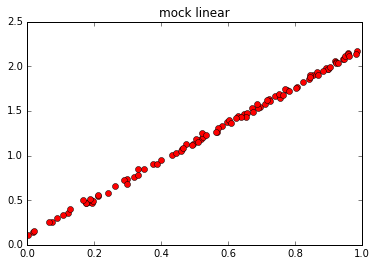

In [4]:
noise = np.random.normal(0, 0.02, (100, 1))
y = y + noise
plt.plot(x, y, 'ro')
plt.title("mock linear")

Construct the model:

In [5]:
x_ = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])
w = tf.Variable(tf.zeros([1,1]))
b = tf.Variable(tf.zeros([1,1]))
predict = x_ * w + b

Define loss function (mean square) and optimize:

In [6]:
loss = tf.reduce_mean(tf.square(y_ - predict))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

Run the graph, training for $w$ and $b$:
<img src="./linear.PNG" alt="A Simple Linear Model" width="35%">

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)

for i in range(501):
    sess.run(train, feed_dict={x_: x, y_: y})
    if i % 50 == 0:
        print i, sess.run(w), sess.run(b)

0 [[ 0.88675141]] [[ 1.28209507]]
50 [[ 2.02658725]] [[ 0.14515524]]
100 [[ 2.08938527]] [[ 0.10762365]]
150 [[ 2.09232688]] [[ 0.10586557]]
200 [[ 2.09246445]] [[ 0.10578342]]
250 [[ 2.09246993]] [[ 0.10578007]]
300 [[ 2.09246993]] [[ 0.10578007]]
350 [[ 2.09246993]] [[ 0.10578007]]
400 [[ 2.09246993]] [[ 0.10578007]]
450 [[ 2.09246993]] [[ 0.10578007]]
500 [[ 2.09246993]] [[ 0.10578007]]


## Step 3: Play on MNIST

In this step, we will introduce a basic machine learning flow and some useful operations. Let's play on MNIST.

MNIST data reader API:
* datasets = read_data_sets(path, fake_data, one_hot)
* dataset.next_batch(number_samples, fake_data)
* dataset.images
Let's see an example from MNIST

Extracting ../repo/MNIST/train-images-idx3-ubyte.gz
Extracting ../repo/MNIST/train-labels-idx1-ubyte.gz
Extracting ../repo/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../repo/MNIST/t10k-labels-idx1-ubyte.gz


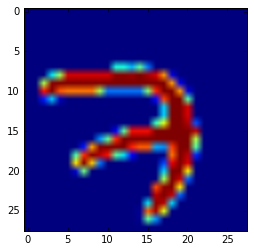

In [3]:
mnist = input_data.read_data_sets("../repo/MNIST", one_hot = True)
imgs = mnist.train.images
img = imgs[0].reshape(28, 28)
plt.imshow(img)

### 3.1 Softmax

In this section, we will introduce:
* softmax activcation: $sofmax(x)_i = \frac{\exp({x_i})}{\sum_j \exp({x_j})}$
* cross entropy: 
$H(p, q) = -\sum_x p(x)\, \log q(x)$

The hypothesis of $K$-class softmax regression, assume the parameter is $\theta$:
<img src="./softmax.PNG" alt="The hypothesis of softmax regression" width="80%">
The cost function can be cross entropy.

In short, Softmax regression (or multinomial logistic regression) is a generalization of logistic regression to the case where we want to handle multiple classes. For detailed information about softmax regression (including the relationship to logistic regression), please refer to: http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/

In Tensorflow:
* __nn.softmax (logits, name=None)__: Computes softmax activations. For each batch i and class j we have _softmax[i, j] = exp(logits[i, j]) / sum(exp(logits[i]))_

We can use the activation function with input multiplied by the parameter $\theta$.


In [35]:
sess = tf.Session()

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])
theta = tf.Variable(tf.zeros([784, 10]))

# softmax model
y = tf.nn.softmax(tf.matmul(x, theta))

# train
loss = -tf.reduce_sum(y_*tf.log(y))
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

sess.run(tf.initialize_all_variables())
for i in range(1000):
	batch = mnist.train.next_batch(50)
	sess.run(train, feed_dict={x: batch[0], y_: batch[1]})

# prediction by direct argmax
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_,1)), "float"))

writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)

print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9127


In [71]:
sess = tf.Session()

def weight_variables(shape):
    #initial = tf.constant(0.0, shape = shape)
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def bias_variables(shape):
	initial = tf.constant(0.0, shape = shape)
	return tf.Variable(initial)

x = tf.placeholder("float", shape=[None, 784])
y_ = tf.placeholder("float", shape=[None, 10])

#activation = tf.nn.relu
activation = tf.sigmoid

learning_rate = 0.01

# hidden
num1 = 128
theta1 = weight_variables([784, num1])
bias1 = bias_varibales([num1])
x1 = activation(tf.matmul(x, theta1) + bias1)

# hidden
num2 = 32
theta2 = weight_variables([784, num2])
bias2 = bias_varibales([num2])
x2 = activation(tf.matmul(x, theta2) + bias2)

# softmax model
theta0 = weight_variables([num2, 10])
bias0 = bias_varibales([10])
y = tf.nn.softmax(tf.matmul(x2, theta0) + bias0)

# train
loss = -tf.reduce_sum(y_*tf.log(y))
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

sess.run(tf.initialize_all_variables())
for i in range(1000):
	batch = mnist.train.next_batch(50)
	sess.run(train, feed_dict={x: batch[0], y_: batch[1]})

# prediction by direct argmax
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y,1), tf.argmax(y_,1)), "float"))

writer = tf.train.SummaryWriter("/root/compute/log", sess.graph)

print sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels})

0.9276


### 3.2 CNN

In addition to the softmax classifier, the feature is automatically learned through multiple CNN layers. We will introduce:
* basic idea of CNN. Detailed CNN description can be found at: http://cs231n.github.io/convolutional-networks/
* nn.conv2d
* nn.max_pool

In [8]:
def weight_variable(shape):
    #initial = tf.constant(0.0, shape = shape)
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
	initial = tf.constant(0.1, shape = shape)
	return tf.Variable(initial)

def conv2d(x, W):
	return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
	return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Input:

In [9]:
x = tf.placeholder("float", shape=[None, 784])
# convert to a stack of images
x_image = tf.reshape(x, [-1, 28, 28, 1])

Construct CNN, train:

In [10]:
# conv1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
#h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_conv1 = tf.sigmoid(conv2d(x_image, W_conv1) + b_conv1)

# conv_e1
W_conv_e1 = weight_variable([5, 5, 32, 32])
b_conv_e1 = bias_variable([32])
#h_conv_e1 = tf.nn.relu(conv2d(h_conv1, W_conv_e1) + b_conv_e1)
h_conv_e1 = tf.sigmoid(conv2d(h_conv1, W_conv_e1) + b_conv_e1)

# max-pool_e1
h_pool_e1 = max_pool_2x2(h_conv_e1)

# conv2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
#h_conv2 = tf.nn.relu(conv2d(h_pool_e1, W_conv2) + b_conv2)
h_conv2 = tf.sigmoid(conv2d(h_pool_e1, W_conv2) + b_conv2)

# max-pool1
h_pool2 = max_pool_2x2(h_conv2)

# dense
final_size = 7*7*64
#final_size = 14*14*32
h_pool2_flat = tf.reshape(h_pool2, [-1, final_size])
#h_pool2_flat = tf.reshape(h_pool1, [-1, final_size])

W_fc1 = weight_variable([final_size, 1024])
b_fc1 = bias_variable([1024])
#h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1 = tf.sigmoid(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# readout
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# train
y_ = tf.placeholder("float", shape=[None, 10])
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
train_step = tf.train.AdamOptimizer(5e-5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(1501):
	batch = mnist.train.next_batch(50)
  	if i%500 == 0:
		train_accuracy = sess.run(accuracy, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
		print("step %d, training accuracy %g"%(i, train_accuracy))
	sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.06
step 500, training accuracy 0.02
step 1000, training accuracy 0.76
step 1500, training accuracy 0.86


Predict on the test data:

In [11]:
batch = mnist.test.next_batch(500)
#plt.imshow(sess.run(h_pool2, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})[0, 0:6, 0:6, 0])
print("test accuracy %g"%sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}))

test accuracy 0.886
